# CIFAR 10 Classification

In this project, you'll classify images from the CIFAR-10 dataset. The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers. At the end, you'll get to see your neural network's predictions on the sample images.

### Download the CIFAR-10 dataset

In [74]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
from tqdm import tqdm_notebook
from time import sleep
import tarfile
import numpy as np

cifar10_dataset_folder_path = 'cifar-10-batches-py'


tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

### Basic Functions Setup

In [75]:
import pickle

def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

label_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [76]:
def show_image(ax, image, label_id):
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label ID: {} - {}'.format(label_id, label_names[label_id]), size = 16)

### Data Exploration

In [77]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

# Data Exploration
images, labels = load_cifar10_batch(cifar10_dataset_folder_path, 1)

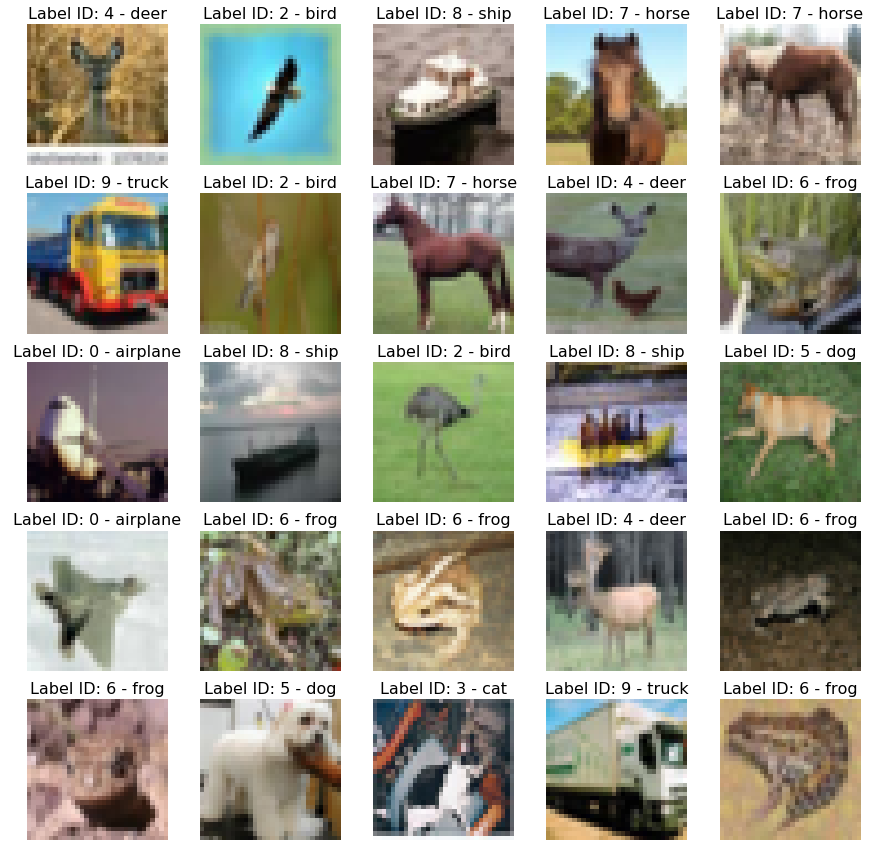

In [78]:
fig, ax = plt.subplots(figsize = (15,15), nrows = 5, ncols = 5)
img_num = random.sample(range(len(labels)), 25)
for i, axis in enumerate(ax.flatten()):
    show_image(axis, images[img_num[i],:,:,:], labels[img_num[i]])

### Analyse the training/sampe distribution in each file

In [79]:
all_labels = []
for i in range(1,6):
    _, labels = load_cifar10_batch(cifar10_dataset_folder_path, i)
    all_labels.append(labels)

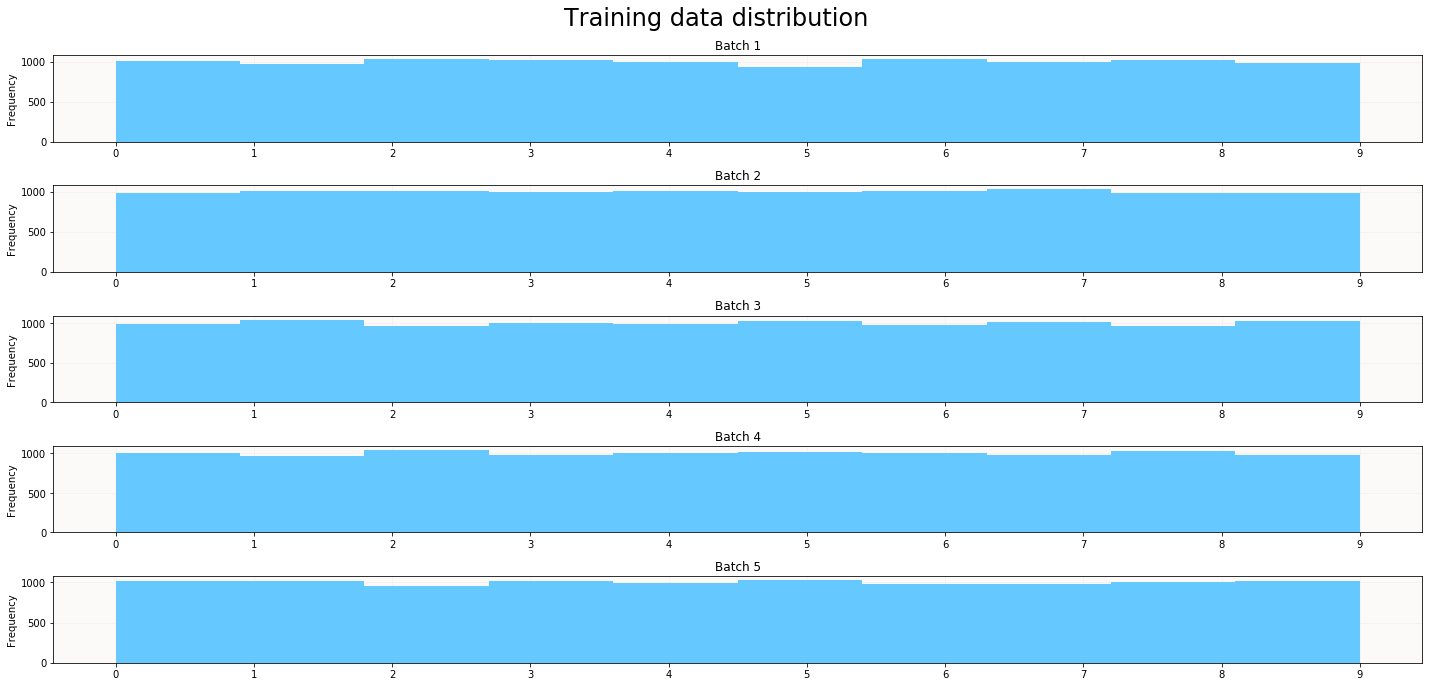

In [80]:
fig, ax = plt.subplots(figsize = (20,10), nrows = 5)
for i, ax_ in enumerate(ax):
    ax_.hist(all_labels[i], color = '#65c9ff')
    ax_.grid(alpha = 0.1)
    ax_.set_axisbelow(True)
    ax_.set_facecolor('#fcfaf8')
    start, end = ax_.get_xlim()
    ax_.xaxis.set_ticks(np.arange(0, 10, 1))
    ax_.set_title('Batch {}'.format(i+1))
    ax_.set_ylabel('Frequency')

fig.suptitle('Training data distribution', size=24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

It seems that we have a good distribution for each of the samples in each batch data. We can use this later to run our Cross Validation during training.

### Preprocessing Functions Setup

In [81]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255

In [82]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    temp = np.zeros((len(x), 10))
    temp[np.arange(len(x)), x] = 1
    
    return temp

In [83]:
def preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cifar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)
    
        # Prprocess and save a batch of training data
        preprocess_and_save(
            normalize,
            one_hot_encode,
            features,
            labels,
            'preprocess_batch_' + str(batch_i) + '.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

### Preprocess data and save it for future usage

In [84]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Network Building

### Input Placeholders

Here we create 3 functions to create placeholders for our neural network later on

In [85]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    x = tf.placeholder(tf.float32, shape = [None, image_shape[0], image_shape[1], image_shape[2]], name = 'x')
    return x 


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.float32, [None, n_classes], name = 'y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name = 'keep_prob')

### Convolution and Max Pooling Layers

Below we will create a higher level function to perform:
1. Convolution
2. Pooling

on our image features. During the network builing process, we'll utilize this function to execute our convolution and pooling for us.

In [86]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight_size = [conv_ksize[0], conv_ksize[1],
                   x_tensor.get_shape().as_list()[3],conv_num_outputs]
    conv_strides = [1, conv_strides[0], conv_strides[1], 1]
    pool_size = [1,pool_ksize[0],pool_ksize[1],1]
    pool_strides = [1, pool_strides[0], pool_strides[1],1]
    
    weight = tf.Variable(tf.truncated_normal(weight_size, 
                                             stddev=1.0/(weight_size[2])**0.5), 
                         name = 'weight')
    
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    conv = tf.nn.conv2d(x_tensor, weight, conv_strides, 'SAME') + bias
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, pool_size, pool_strides, 'SAME')
    return conv


### Flatten

Below we create a function to flatten our final layer form our CNN in order to feed them properly to our NN

In [87]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    size = x_tensor.get_shape().as_list()
    size[0] = 1
    total_size = np.prod(size)
    return tf.reshape(x_tensor, [-1,total_size], name = "flatten")

### Fully Connected Layer

Build a fully connected neural network which receives input from our CNN. We will use relu as our activation function.

In [88]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_size = x_tensor.get_shape().as_list()
    weight_size = [x_size[1], num_outputs]
    weight_full = tf.Variable(tf.truncated_normal(weight_size, stddev=1.0/(weight_size[0])**0.5))
    bias_full = tf.Variable(tf.zeros([num_outputs]))
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, weight_full), bias_full))

### Output Layer

We create output layer which calculates the final logit of our network. This output will be the one we use to determine the prediction based on the input data

In [89]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_size = x_tensor.get_shape().as_list()
    weight_size = [x_size[1], num_outputs]
    weight_full = tf.Variable(tf.truncated_normal(weight_size, stddev=1.0/(weight_size[0])**0.5))
    bias_full = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor,weight_full), bias_full)

### Constructing the network

Now that we have all the functions to build our CNN, we will build one below, with structure as follows:

**Input > [Convolution > Max Pooling] x 2 > Full Connected > Dropout > Fully Connected > Output**

In [90]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # 1st layer CNN, filter = 30
    conv = conv2d_maxpool(x, conv_num_outputs = 30, conv_ksize = [3,3], conv_strides = [2,2],
                          pool_ksize = [3,3], pool_strides = [2,2])
    # 2nd layer CNN, filter = 45
    conv = conv2d_maxpool(conv, conv_num_outputs = 45, conv_ksize = [4,4], conv_strides = [2,2],
                          pool_ksize = [4,4], pool_strides = [2,2])
    
    # Flattern results to a N x 1 dimensional array
    flat = flatten(conv)
    
    # Build a fully connected layer for prediction
    FNN = fully_conn(flat, 40)
    FNN = tf.nn.dropout(FNN, keep_prob)
    FNN = fully_conn(FNN, 20)

    out = output(FNN, 10)

    return out

Setup the network and hyperparameters

In [106]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
conv_keep_prob = neural_net_keep_prob_input()
fnn_keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, fnn_keep_prob)
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [107]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    _, cost, acc = session.run(
        [optimizer, cost, accuracy],
        feed_dict={x: valid_features, y: valid_labels, fnn_keep_prob: 1})
    print('Cost = {:.4f}, Accuracy = {:.2f}%'.format(cost, acc*100))

In [108]:
valid_features, valid_labels = pickle.load(open('preprocess_batch_1.p', mode='rb'))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print_stats(sess, valid_features, valid_labels, cost, accuracy)

Cost = 2.5116, Accuracy = 9.96%


### Setting up Hyperparameters

In [109]:
epochs = 100
batch_size = 256
keep_probability = 0.5
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [110]:
def return_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_file(filename, batch_size):
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return return_batches(features, labels, batch_size)

In [ ]:
hist = []

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in tqdm_notebook(range(epochs), desc='Epoch'):
        for batch_i in range(4):
            filename = 'preprocess_batch_' + str(batch_i+1) + '.p'
            for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                _, train_cost, train_acc = sess.run([optimizer, cost, accuracy],
                                        feed_dict={x: batch_features, 
                                                   y: batch_labels, 
                                                   fnn_keep_prob: 0.5})
        
        # Record performance every 5 epochs
        if (epoch+1)%5 == 0:
            valid_batch_acc_total = 0
            valid_batch_count = 0
            for valid_feature_batch, valid_label_batch in load_preprocess_file('preprocess_batch_5.p', batch_size):
                valid_cost, acc = sess.run([cost, accuracy], 
                               feed_dict= {x: valid_feature_batch, y: valid_label_batch, fnn_keep_prob: 1.0})

                valid_batch_acc_total += acc
                valid_batch_count += 1
            hist.append([train_cost, train_acc, valid_cost, valid_batch_acc_total/valid_batch_count])
        
        #if (epoch+1)%5 == 0:
            #sleep(1)
            #tqdm.write('Epoch {:>2}:, Validation Acc.  '.format(epoch + 1, valid_batch_acc_total/valid_batch_count*100), end='')
            #print_stats(sess, batch_features, batch_labels, cost, accuracy)
hist = np.array(hist)

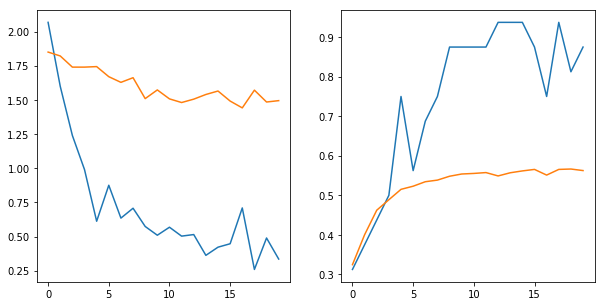

In [129]:
fig, ax = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)

ax[0].plot(hist[:,0])
ax[0].plot(hist[:,2])
ax[1].plot(hist[:,1])
ax[1].plot(hist[:,3])

### Cross Validation for Hyper Parameters Selection

In [130]:
def conv_net2(conv, conv_keep_prob, fnn_keep_prob,
              conv_layer_param = [(30, 3, 2), (45, 4, 2)], 
              full_layer_param = [40, 20], 
              normalize=False):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : conv_keep_prob: Placeholder tensor that hold dropout keep probability.
    : fnn_keep_prob
    : normalize: Use batch normalization
    : conv_layer_param: list of conv net configuration (filter, conv_ksize, pool_ksize).
                        size of list represents # of conv layer
    : full_layer_param: list of fully connected layer size (excluding last layer).
                        size of list represents # of fully connected layer
    : return: Tensor that represents logits
    """
    
    for filter_size, conv_ksize, pool_ksize in conv_layer_param:
        conv = conv2d_maxpool(conv, conv_num_outputs = filter_size, 
                              conv_ksize = [conv_ksize, conv_ksize], conv_strides = [2,2],
                              pool_ksize = [pool_ksize, pool_ksize], pool_strides = [2,2])
        conv = tf.nn.dropout(conv, conv_keep_prob)
    
    # Flattern results to a N x 1 dimensional array
    FNN = flatten(conv)
    
    # Build a fully connected layer for prediction
    for layer_size in full_layer_param:
        FNN = fully_conn(FNN, layer_size)
        FNN = tf.nn.dropout(FNN, fnn_keep_prob)

    out = output(FNN, 10)

    return out

In [131]:
def cross_validation(sess, epochs, conv_keep_probability, 
                     fnn_keep_probability):
    l = list(range(1,6))
    cv = [(l[:k] + l[(k + 1):],[k+1]) for k in range(len(l))]
    
    validation_hist = []
    
    for train, validate in cv:
        sess.run(tf.global_variables_initializer())
        
        for epoch in tqdm_notebook(range(epochs), desc='Epochs'):
            for batch_i in train:
                    filename = 'preprocess_batch_' + str(batch_i) + '.p'
                    for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                        _, acc = sess.run([optimizer, accuracy],
                                             feed_dict={x: batch_features, 
                                                        y: batch_labels, 
                                                        conv_keep_prob: conv_keep_probability,
                                                        fnn_keep_prob: fnn_keep_probability})
        
        # Get accuracy in batches for memory limitations
        valid_batch_acc_total = 0
        valid_batch_count = 0
        
        filename = 'preprocess_batch_' + str(validate[0]) + '.p'
        for valid_feature_batch, valid_label_batch in load_preprocess_file(filename, batch_size):
            acc = sess.run(accuracy, 
                           feed_dict= {x: valid_feature_batch, 
                                       y: valid_label_batch, 
                                       conv_keep_prob: 1.0,
                                       fnn_keep_prob: 1.0})
            
            valid_batch_acc_total += acc
            valid_batch_count += 1 
        
        validation_hist.append(valid_batch_acc_total/valid_batch_count)
    
    return np.mean(validation_hist)

In [135]:
epochs_all = [100, 150]
batch_size = 256
conv_keep_probability_all = [0.1, 0.2]
fnn_keep_probability_all = [0.5]
conv_layer_param = [[(30, 3, 2), (45, 4, 2)], [(30, 3, 2), (45, 4, 2), (60, 4, 2)]]
full_layer_param = [[40, 20], [60, 40, 20]]
learning_rate_all = [0.001, 0.003]

In [136]:
import itertools

print('Training...')
perm = itertools.product(epochs_all, conv_keep_probability_all, 
                         fnn_keep_probability_all, conv_layer_param,
                         full_layer_param, learning_rate_all)

bestval = 0
besthyperparam = ()
performance_history = []

history_file = open('performance_history.txt', 'w')
for epochs, conv_keep_probability, fnn_keep_probability,\
    conv_param, full_param, learning_rate in tqdm_notebook(perm, desc='Perm'):
    
    hyperparam = (epochs, batch_size, conv_keep_probability, 
                  fnn_keep_probability, conv_param, full_param, learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Update Model
    logits = conv_net2(x, conv_keep_prob, fnn_keep_prob, conv_param, full_param)
    logits = tf.identity(logits, name='logits')
    
    with tf.Session() as sess:
        # Training cycle
        validation_acc = cross_validation(sess, epochs, conv_keep_probability, fnn_keep_probability)
        
        if bestval < validation_acc: besthyperparam = hyperparam
        
        performance_history.append((epochs, batch_size, conv_keep_probability, 
                                    fnn_keep_probability, conv_param, full_param,
                                    learning_rate, validation_acc*100))
        history_file.write("%s\n" % performance_history[-1])
        #sleep(0.1)
        #tqdm.write("E= {}, Conv p= {}, FNN p= {}, Conv Set= {}, Full Set= {}, Lr= {} | Validation Accuracy= {:.2f}%".\
        #     format(epochs, conv_keep_probability, fnn_keep_probability,
        #            conv_layer_param.index(conv_param), full_layer_param.index(full_param),
        #            learning_rate, validation_acc*100))

history_file.close()

Training...




TypeError: not all arguments converted during string formatting

In [139]:
history_file.write("{}\n".format(performance_history[-1]))

84

In [137]:
performance_history

[(100,
  256,
  0.1,
  0.5,
  [(30, 3, 2), (45, 4, 2)],
  [40, 20],
  0.001,
  54.888671875000007)]

## Train Final Model

In [ ]:
epochs = 60
batch_size = 256
keep_probability = 0.5
learning_rate = 0.001

epochs, batch_size, conv_keep_probability, fnn_keep_probability, conv_param, full_param, learning_rate = besthyperparam
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
logits = conv_net2(x, conv_keep_prob, fnn_keep_prob, conv_param, full_param)
logits = tf.identity(logits, name='logits')

save_model_path = './image_classification'

In [ ]:
print(epochs, batch_size, conv_keep_probability, 
                  fnn_keep_probability, conv_param, full_param, learning_rate)

In [ ]:
print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in tqdm(range(epochs)):
        
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            filename = 'preprocess_batch_' + str(batch_i) + '.p'
            for batch_features, batch_labels in load_preprocess_file(filename, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        
        #show only batch 5
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in return_batches(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})